<a href="https://colab.research.google.com/github/sudheervobili/Pytorch/blob/main/home_loan_prediction_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Home Loan Prediction (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Importing dataset from kaggle using CLI

In [3]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp "Kaggle (3).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download taweilo/loan-approval-classification-data
!unzip loan-approval-classification-data.zip

Saving Kaggle (3).json to Kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data
License(s): apache-2.0
  0% 0.00/751k [00:00<?, ?B/s]
100% 751k/751k [00:00<00:00, 695MB/s]
Archive:  loan-approval-classification-data.zip
  inflating: loan_data.csv           


In [4]:
df = pd.read_csv('loan_data.csv')

In [5]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [6]:
df.shape

(45000, 14)

In [7]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## Exploratory Data Analysis:
1. Checking Null Values
2. Detecting Outliers in the dataset via Box plot
3. Distribution Over Categorial variables
4. Distribution Over Numerical variables
5. Analyzing Correlation between variables
6. Identifying Important Features that Effects on Targer column

In [9]:
df.isnull().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

In [11]:
def remove_outliers(df, columns, threshold=1.5, method='any'):
    """
    Remove outliers from dataframe

    Parameters:
    - method: 'any' (remove if outlier in ANY column) or 'all' (remove if outlier in ALL columns)
    - threshold: IQR multiplier for outlier detection
    """
    df_clean = df.copy()

    print(f"Original dataset shape: {df.shape}")

    # Create a mask to track outliers - start with False for all rows
    outlier_mask = pd.Series([False] * len(df), index=df.index)

    # Store individual column outlier masks for debugging
    column_outlier_masks = {}

    for i, col in enumerate(columns):
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in dataframe")
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Handle case where IQR = 0 (all values the same)
        if IQR == 0:
            print(f"Warning: Column '{col}' has IQR = 0 (no variation), skipping...")
            continue

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_count = col_outliers.sum()

        print(f"Column '{col}': {outlier_count} outliers found")
        print(f"  Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"  Min value: {df[col].min():.2f}, Max value: {df[col].max():.2f}")

        # Store for debugging
        column_outlier_masks[col] = col_outliers

        if method == 'any':
            # OR operation: mark for removal if outlier in ANY column
            outlier_mask = outlier_mask | col_outliers
        elif method == 'all':
            if i == 0:  # First column
                outlier_mask = col_outliers.copy()
            else:
                # AND operation: only keep if outlier in ALL columns
                outlier_mask = outlier_mask & col_outliers

    # Remove outliers
    df_clean = df[~outlier_mask]

    print(f"\nFinal dataset shape: {df_clean.shape}")
    print(f"Removed {len(df) - len(df_clean)} rows ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")

    return df_clean

# Debugging function to understand outlier distribution
def analyze_outliers(df, columns, threshold=1.5):
    """
    Analyze outliers without removing them
    """
    print("=== OUTLIER ANALYSIS ===")

    outlier_summary = {}

    for col in columns:
        if col not in df.columns:
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0:
            print(f"{col}: No variation (IQR=0)")
            continue

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_indices = df[outliers].index.tolist()

        outlier_summary[col] = {
            'count': outliers.sum(),
            'percentage': (outliers.sum() / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outlier_indices': outlier_indices
        }

        print(f"\n{col}:")
        print(f"  Outliers: {outliers.sum()} ({outlier_summary[col]['percentage']:.1f}%)")
        print(f"  Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"  Data range: [{df[col].min():.2f}, {df[col].max():.2f}]")

    return outlier_summary

# Example usage:
# First, analyze your outliers
# outlier_info = analyze_outliers(df, ['column1', 'column2'])

# Then remove them with method='any' (recommended)
# df_clean = remove_outliers(df, ['column1', 'column2'], method='any')

In [12]:
df_cleaned = remove_outliers(df, num_cols)

Original dataset shape: (45000, 14)
Column 'person_age': 2188 outliers found
  Range: [15.00, 39.00]
  Min value: 20.00, Max value: 144.00
Column 'person_income': 2218 outliers found
  Range: [-25673.88, 168667.12]
  Min value: 8000.00, Max value: 7200766.00
Column 'person_emp_exp': 1724 outliers found
  Range: [-9.50, 18.50]
  Min value: 0.00, Max value: 125.00
Column 'loan_amnt': 2348 outliers found
  Range: [-5855.88, 23093.12]
  Min value: 500.00, Max value: 35000.00
Column 'loan_int_rate': 124 outliers found
  Range: [1.99, 19.59]
  Min value: 5.42, Max value: 20.00
Column 'loan_percent_income': 744 outliers found
  Range: [-0.11, 0.37]
  Min value: 0.00, Max value: 0.66
Column 'cb_person_cred_hist_length': 1366 outliers found
  Range: [-4.50, 15.50]
  Min value: 2.00, Max value: 30.00
Column 'credit_score': 467 outliers found
  Range: [497.50, 773.50]
  Min value: 390.00, Max value: 850.00

Final dataset shape: (37549, 14)
Removed 7451 rows (16.6%)


In [13]:
df_cleaned.shape

(37549, 14)

In [45]:
def plot_seaborn_comparison_large(df, df_cleaned, columns, width_per_col=6, height=8):
    # Prepare data for seaborn
    original_data = []
    cleaned_data = []

    for col in columns:
        # Original data
        for val in df[col].dropna():
            original_data.append({'Column': col, 'Value': val, 'Type': 'Original'})

        # Cleaned data
        for val in df_cleaned[col].dropna():
            cleaned_data.append({'Column': col, 'Value': val, 'Type': 'Cleaned'})

    # Combine data
    plot_data = pd.DataFrame(original_data + cleaned_data)

    # Create subplots with dynamic width
    n_cols = len(columns)
    total_width = width_per_col * n_cols
    fig, axes = plt.subplots(1, n_cols, figsize=(total_width, height))

    if n_cols == 1:
        axes = [axes]

    # Set style for better appearance
    sns.set_style("whitegrid")

    for i, col in enumerate(columns):
        col_data = plot_data[plot_data['Column'] == col]
        sns.boxplot(data=col_data, x='Type', y='Value', ax=axes[i],
                   palette=['lightblue', 'lightcoral'])
        axes[i].set_title(f'{col}', fontsize=16, fontweight='bold', pad=20)
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='both', which='major', labelsize=13)
        axes[i].set_xlabel('Type', fontsize=14, fontweight='bold')
        axes[i].set_ylabel('Value', fontsize=14, fontweight='bold')

    plt.tight_layout(pad=3.0)
    plt.show()

In [28]:
num_cols1 = df_cleaned.select_dtypes(include=[np.number]).columns
cat_cols1 = df_cleaned.select_dtypes(exclude=[np.number]).columns

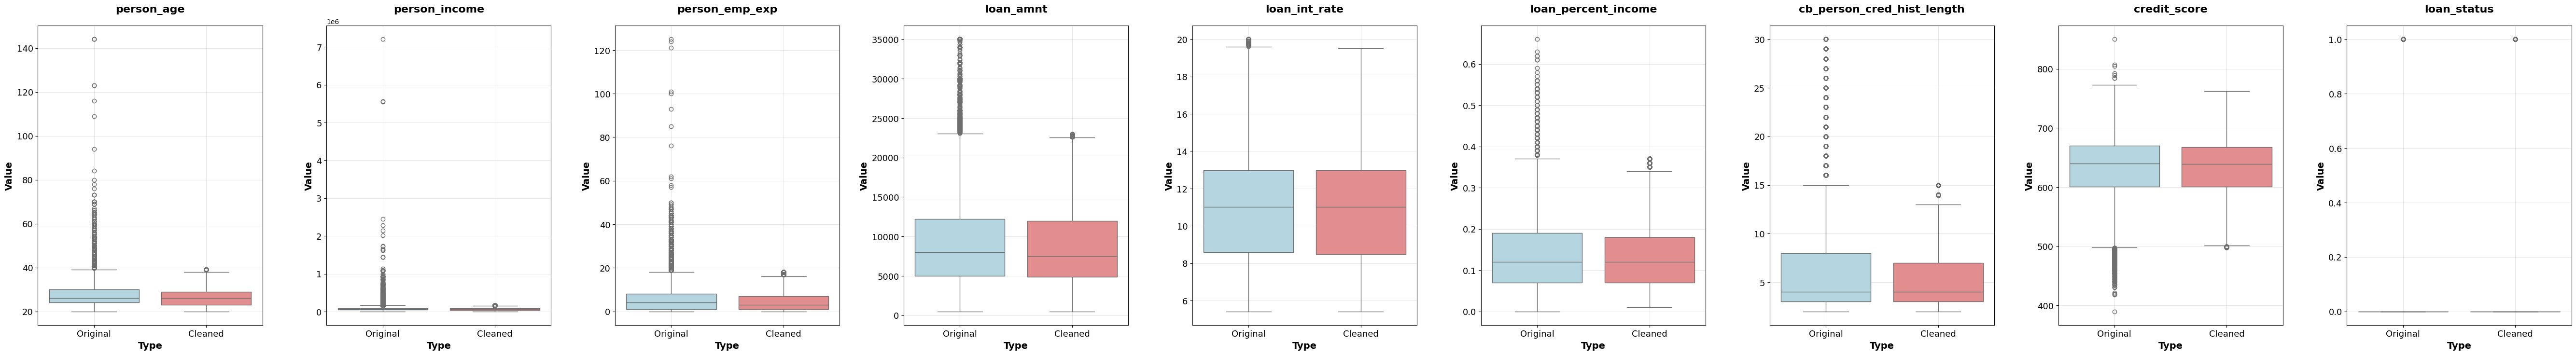

In [16]:
plot_seaborn_comparison_large(df, df_cleaned, num_cols1)

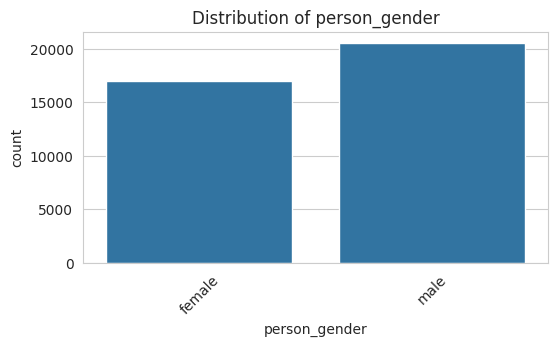

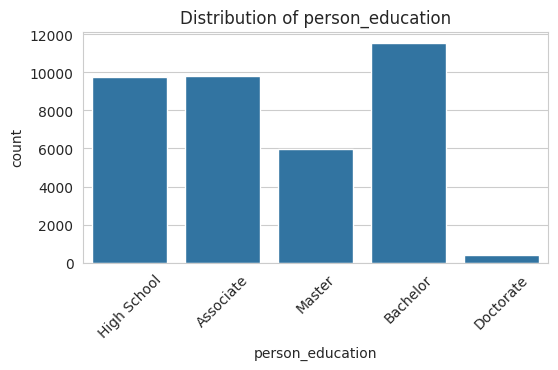

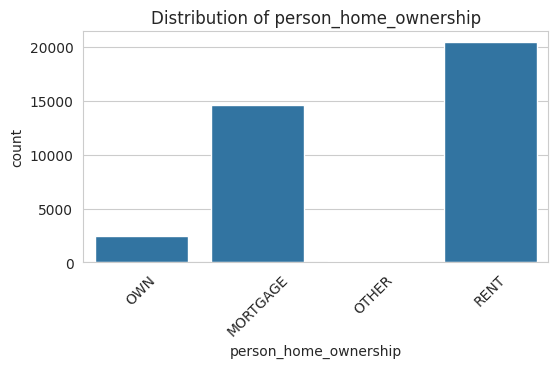

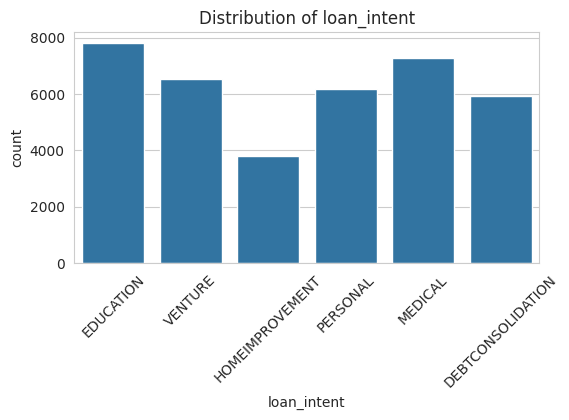

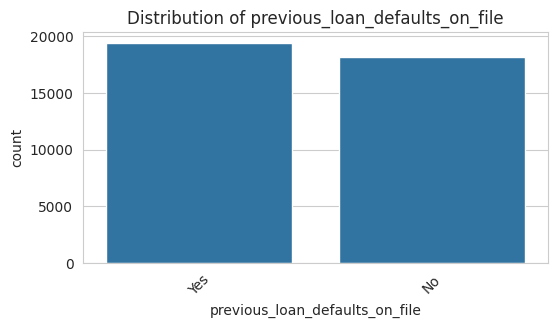

In [17]:
for col in cat_cols1:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df_cleaned, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

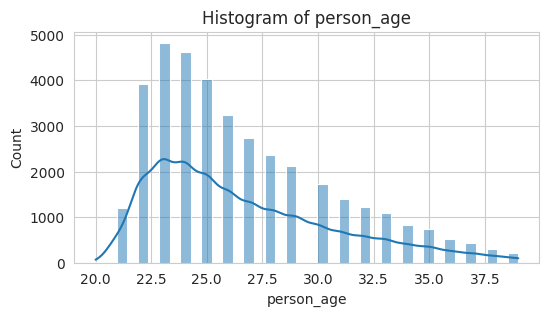

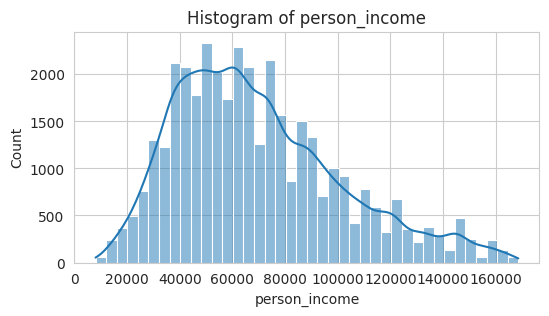

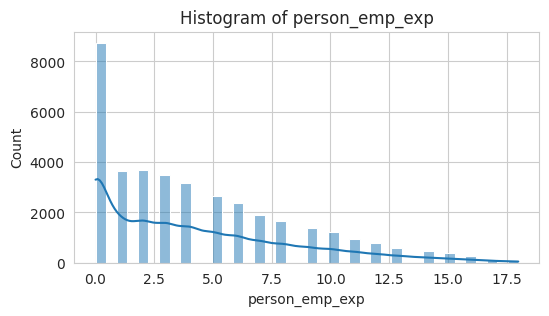

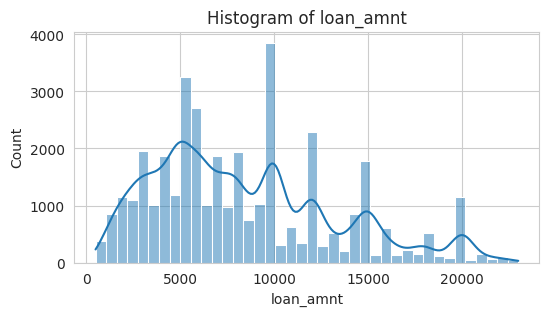

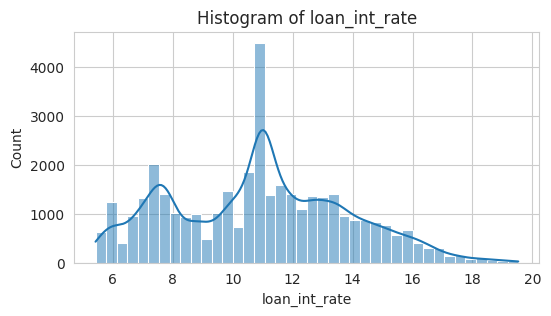

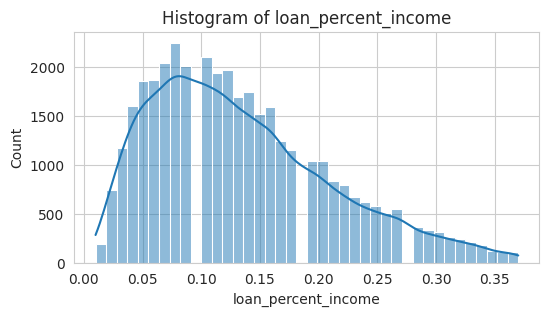

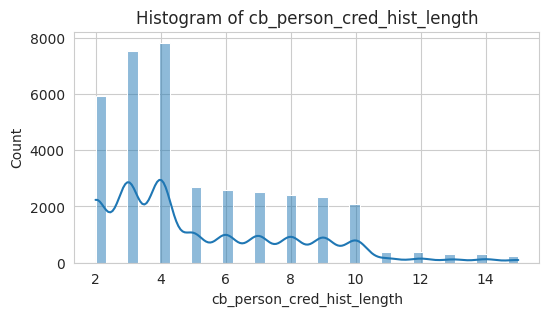

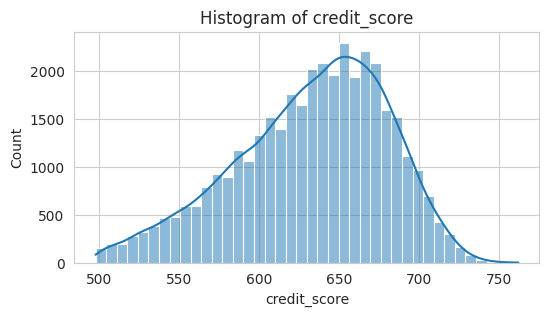

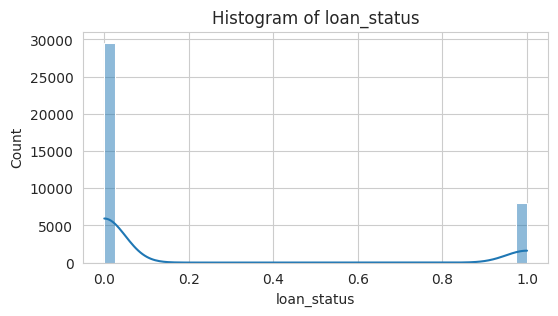

In [18]:
for col in num_cols1:
    plt.figure(figsize=(6, 3))
    sns.histplot(df_cleaned[col], kde=True, bins=40)
    plt.title(f"Histogram of {col}")
    plt.show()

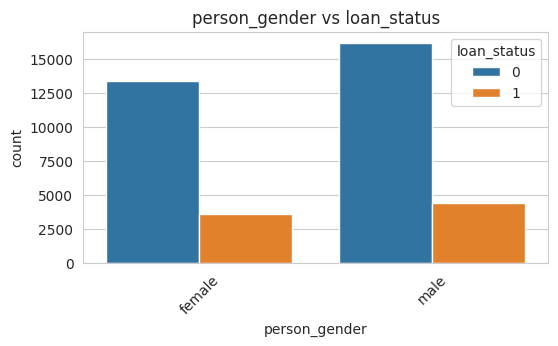

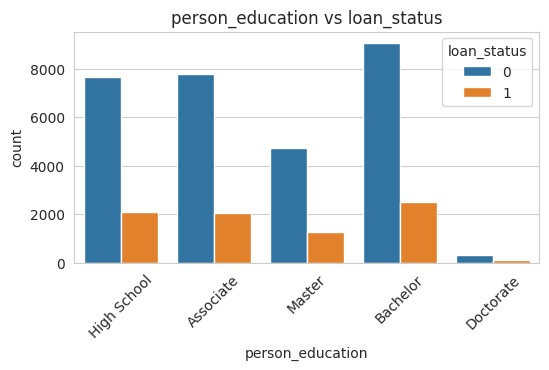

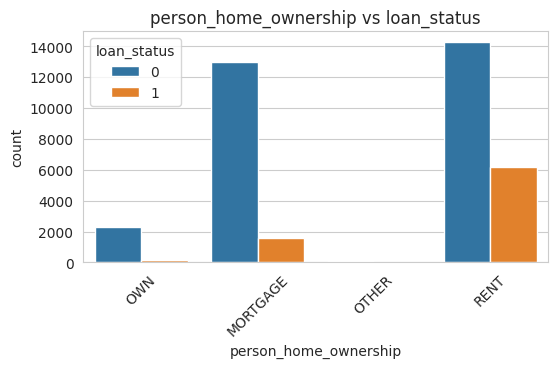

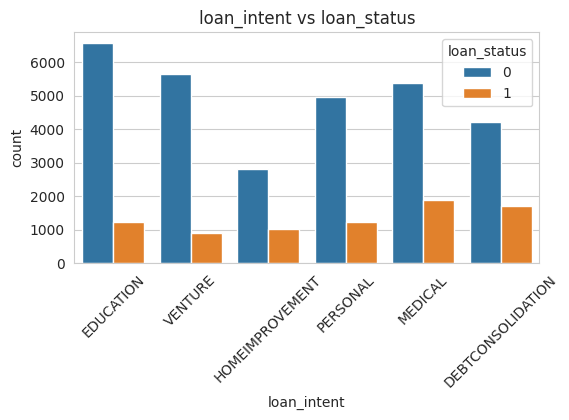

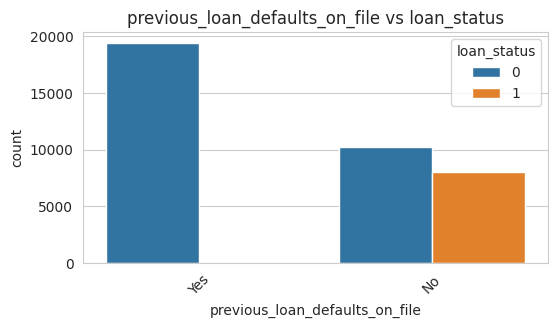

In [19]:
target = "loan_status"
for col in cat_cols1:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df_cleaned, x=col, hue=target)
    plt.title(f"{col} vs {target}")
    plt.xticks(rotation=45)
    plt.show()

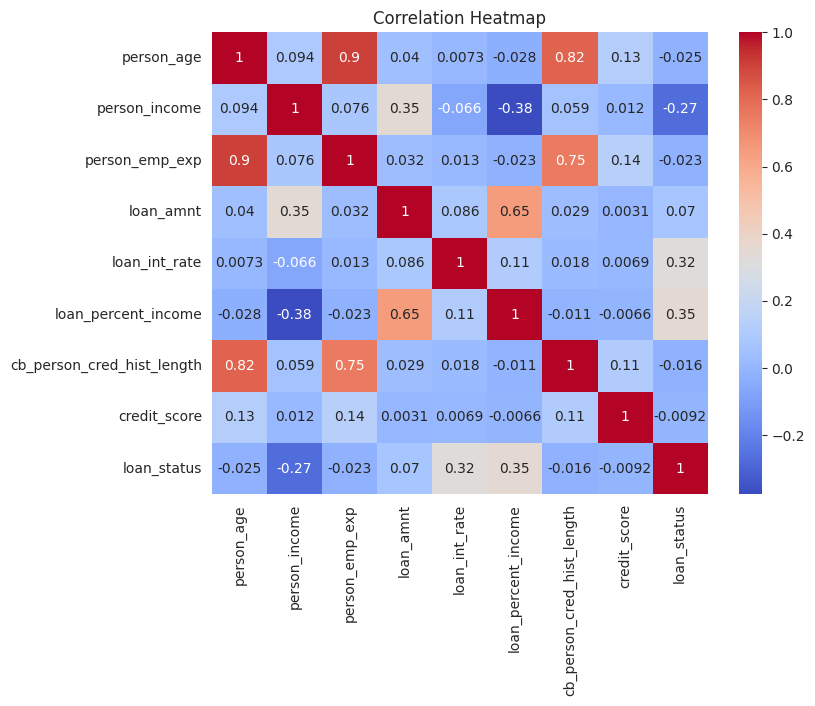

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_cleaned[num_cols1].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [21]:
df_cleaned.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1
11,21.0,female,Associate,13113.0,0,OWN,4500.0,HOMEIMPROVEMENT,8.63,0.34,2.0,651,No,1
19,24.0,female,Master,14283.0,1,MORTGAGE,1750.0,EDUCATION,10.99,0.12,2.0,679,No,1


In [22]:
X = df_cleaned.drop('loan_status', axis=1)
y = df_cleaned['loan_status']

# Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
print("Training Size:", X_train.shape, "Testing Size:", X_test.shape)

Training Size: (30039, 13) Testing Size: (7510, 13)


In [29]:
target_col = 'Loan_Status'  # or whatever your target column is
num_cols1 = [col for col in X_train.columns if col != target_col and X_train[col].dtype != 'object']


In [44]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. Encode categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols1])
X_test_cat = ohe.transform(X_test[cat_cols1])

# Convert to DataFrame with proper column names
ohe_columns = ohe.get_feature_names_out(cat_cols1)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=ohe_columns, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=ohe_columns, index=X_test.index)

# 2. Scale numeric columns
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols1]),
                           columns=num_cols1, index=X_train.index)
X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols1]),
                          columns=num_cols1, index=X_test.index)

# 3. Combine categorical and numerical
X_train_final = pd.concat([X_train_num, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat_df], axis=1)


In [32]:
X_train_final.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_female,person_gender_male,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
1114,-0.635076,1.460067,-0.549414,1.838615,-0.176513,0.207885,-1.096729,-0.280106,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25490,0.096724,-0.577980,0.661877,-1.114759,-0.663793,-0.960993,-0.058721,-0.238151,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3063,-0.635076,-0.839824,-0.549414,-0.294378,-1.863252,0.337761,-0.750727,1.377112,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
22681,1.316390,-0.010609,1.873168,0.115813,0.838937,-0.051865,-0.058721,0.747789,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
17610,-0.147209,0.407222,-0.549414,1.346386,1.908908,0.597512,-0.750727,1.544931,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    solver='liblinear',   # good for binary, smaller datasets
    random_state=42
    # class_weight='balanced',  # uncomment if classes are imbalanced
)
log_reg.fit(X_train_final, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

Accuracy: 0.896404793608522
Precision: 0.7718729747245625
Recall: 0.7365491651205937
F1: 0.7537974683544304
ROC-AUC: 0.9539575113015757

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      5893
           1       0.77      0.74      0.75      1617

    accuracy                           0.90      7510
   macro avg       0.85      0.84      0.84      7510
weighted avg       0.89      0.90      0.90      7510

Confusion Matrix:
 [[5541  352]
 [ 426 1191]]


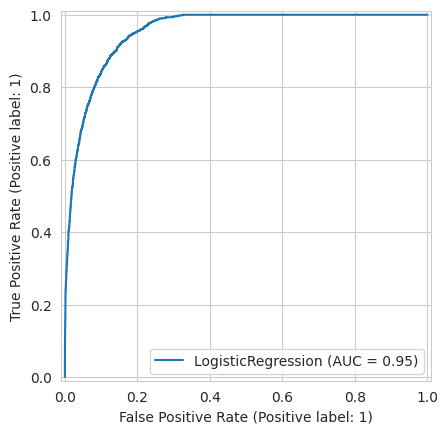

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
#import matplotlib.pyplot as plt

# Predictions
y_pred = log_reg.predict(X_test_final)
y_proba = log_reg.predict_proba(X_test_final)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC Curve
RocCurveDisplay.from_estimator(log_reg, X_test_final, y_test)
plt.show()


In [40]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest

In [43]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_final, y_train)
y_pred_rf = rf.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9255659121171771
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5893
           1       0.89      0.75      0.81      1617

    accuracy                           0.93      7510
   macro avg       0.91      0.86      0.88      7510
weighted avg       0.92      0.93      0.92      7510

Confusion Matrix:
 [[5736  157]
 [ 402 1215]]
